In [272]:
import tensorflow as tf
import numpy as np

from tensorflow.python.layers import core as layers_core
from prepare_data import get_decoder_data_int_sequences

from matplotlib import pyplot as plt
from tensor2tensor.layers.common_attention import add_timing_signal_nd #currently not in use


In [273]:
tf.reset_default_graph()

In [274]:
### Outline

# 1. Encoder
# 2. Decoder
# 3. Optimization and training


# What is bucketing?



In [275]:
buckets_dict = {(40, 160): 0,
 (40, 200): 1,
 (40, 240): 2,
 (40, 280): 3,
 (40, 320): 4,
 (40, 360): 5,
 (50, 120): 6,
 (50, 200): 7,
 (50, 240): 8,
 (50, 280): 9,
 (50, 320): 10,
 (50, 360): 11,
 (50, 400): 12,
 (60, 360): 13,
 (100, 360): 14,
 (100, 500): 15,
 (160, 400): 16,
 (200, 500): 17,
 (800, 800): 18}

buckets = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
mini_batch_size = 32



def load_raw_data(dataset_name, max_token_length = 400, max_num_samples = 5000):

    
    dataset = []
    
    if dataset_name == "small":
        image_folder = 'data/tin/tiny/'
        formula_file_path = "data/tin/tiny.formulas.norm.txt"
    elif dataset_name == "test":
        image_folder = 'data/images_test/'
        formula_file_path = "data/test.formulas.norm.txt"
    elif dataset_name == "train":
        image_folder = 'data/images_train/'
        formula_file_path = "data/train.formulas.norm.txt"
    elif dataset_name == "val":
        image_folder = 'data/images_val/'
        formula_file_path = "data/val.formulas.norm.txt"
    elif dataset_name == "digital_numbers":
        image_folder = 'datasets/digital_numbers/images/'
        formula_file_path = "datasets/digital_numbers/number_sequences.txt"

        
    included_counter = 0
    examples_counter = 0
    with open (formula_file_path, "r") as myfile:

        for idx, token_sequence in enumerate(myfile):
            examples_counter += 1
            #Check token size:
            token_sequence = token_sequence.rstrip('\n')
            tokens = token_sequence.split()

            file_name = str(idx) + '.png'
            image = cv2.imread(image_folder + file_name, 0)
            
            if image is None:
                print("Id:", idx)
                continue
            
            
            #print(tokens)
            if len(tokens) <= max_token_length:
                
                token_sequence = '**start** ' + token_sequence
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Grey scale
                #print(image)
                
                seq_length = len(token_sequence.split())
                
                relevant_bucket_id = buckets_dict[image.shape]
                #print(relevant_bucket_id)
                #print(buckets[relevant_bucket_id])
                buckets[relevant_bucket_id].append([image, token_sequence, seq_length])
                
                
                
                #print("Bucket " + str(buckets_dict[image.shape]) + "size: " + str(len(buckets[buckets_dict[image.shape]])))
                if len(buckets[buckets_dict[image.shape]]) == mini_batch_size:
                    data_batch = np.array(buckets[buckets_dict[image.shape]])
                    dataset.append(data_batch)
                    buckets[buckets_dict[image.shape]] = []

                included_counter += 1
                if included_counter == max_num_samples:
                    break

                #print(dataset)
        for idx, bucket in enumerate(buckets):
            if len(bucket) != 0:
                data_batch = np.array(bucket)
                dataset.append(data_batch)
                buckets[idx] = []
        
            
    return dataset

In [276]:
# dataset is list of all batches containing (image, target_text, sequence_length)
# we split that up into three lists


def split_dataset(dataset):

    encoder_input_data_batches = []
    target_texts_batches = []
    sequence_lengths_batches = []

    for batch in range(len(dataset)):
        image_batch = dataset[batch][:,0]
        image_batch = image_batch.tolist()
        image_batch = np.array(image_batch)
        # Add one dimension so that the conv net can take it (it expects four dimensions)
        image_batch = np.reshape(image_batch, (image_batch.shape[0], image_batch.shape[1], image_batch.shape[2], 1))
        image_batch = image_batch.astype('uint8')

        
        encoder_input_data_batches.append(image_batch)

        target_text = dataset[batch][:,1]
        target_texts_batches.append(target_text)

        decoder_length = dataset[batch][:,2]
        decoder_length = np.array(decoder_length)
        sequence_lengths_batches.append(decoder_length)

    # Make sure we have equal number of batches
    assert (len(encoder_input_data_batches) == len(dataset))
    assert (len(target_texts_batches) == len(dataset))
    assert (len(sequence_lengths_batches) == len(dataset))
    
    return encoder_input_data_batches, target_texts_batches, sequence_lengths_batches

In [277]:
def get_vocabulary(dataset):
    if dataset == "small":
        vocab = [line for line in open('data/tin/tiny_vocab.txt')]
    elif dataset == "test":
        vocab = [line for line in open('data/vocab.txt')]
    elif dataset == "train":
        vocab = [line for line in open('data/vocab.txt')]

    vocab = [x.strip('\n') for x in vocab]
    return vocab

In [278]:
# Create the vocabulary

token_vocabulary = []
token_vocabulary.append("**end**") # Want this to be the first token
token_vocabulary.append("**start**")
token_vocabulary.append("**unknown**")

token_vocabulary.extend(get_vocabulary("train"))

target_tokens = token_vocabulary # TODO: Refactor this. Currently duplicate naming

token_vocab_size = len(target_tokens)

target_token_index = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_target_token_index = dict(
    (i, char) for char, i in target_token_index.items())

In [279]:
#print(len(token_vocabulary))

In [280]:
def create_output_int_sequences(target_texts_batches, sequence_lengths_batches):
    decoder_input_data_batches = []
    decoder_target_data_batches = []
    
    for idx, target_texts_batch in enumerate(target_texts_batches):
    
        # get max dec seq length for that batch
        max_decoder_seq_length = max(sequence_lengths_batches[idx])

        batch_size = len(target_texts_batch)
        
        decoder_input_data = np.zeros(
                (batch_size, max_decoder_seq_length),
                dtype='int32')
        decoder_target_data = np.zeros(
                (batch_size, max_decoder_seq_length),
                dtype='int32')

        num_other = 0

        for i, target_text in enumerate(target_texts_batch):
            for t, token in enumerate(target_text.split()):
                
                if token in target_token_index:
                    # decoder_target_data is ahead of decoder_input_data by one timestep

                    decoder_input_data[i, t] = target_token_index[token]

                    if t > 0:
                        #decoder_target_data will be ahead by one timestep
                        # and will not include the start character.
                        decoder_target_data[i, t - 1] = target_token_index[token]

                else:
                    print("Token not in vocabulary (setting to **unknown**): ", token)
                    num_other = num_other + 1
                    decoder_input_data[i, t] = target_token_index['**unknown**']

                    if t > 0:
                        #decoder_target_data will be ahead by one timestep
                        # and will not include the start character.

                        decoder_target_data[i, t - 1] = target_token_index['**unknown**']

            decoder_target_data[i, len(target_text.split()) - 1] = target_token_index['**end**']  
            
            
        
        decoder_input_data_batches.append(decoder_input_data)
        decoder_target_data_batches.append(decoder_target_data)
        
    return decoder_input_data_batches, decoder_target_data_batches

In [281]:
def load_data(dataset_name, max_token_length, max_num_samples):
    dataset = load_raw_data(dataset_name, max_token_length = max_token_length, max_num_samples = max_num_samples)
    encoder_input_data_batches, target_texts_batches, sequence_lengths_batches = split_dataset(dataset)
    decoder_input_data_batches, decoder_target_data_batches = create_output_int_sequences(target_texts_batches, sequence_lengths_batches)    

    return encoder_input_data_batches, target_texts_batches, sequence_lengths_batches, decoder_input_data_batches, decoder_target_data_batches




In [282]:
max_token_length = 50
max_train_num_samples = 200


train_dataset = load_data('train', max_token_length, max_num_samples)
train_encoder_input_data_batches = train_dataset[0]
train_target_texts_batches = train_dataset[1]
train_sequence_lengths_batches = train_dataset[2]
train_decoder_input_data_batches = train_dataset[3]
train_decoder_target_data_batches = train_dataset[4]


val_dataset = load_data('train', max_token_length, max_num_samples)
val_encoder_input_data_batches = val_dataset[0]
val_target_texts_batches = val_dataset[1]
val_sequence_lengths_batches = val_dataset[2]
val_decoder_input_data_batches = val_dataset[3]
val_decoder_target_data_batches = val_dataset[4]


('Token not in vocabulary (setting to **unknown**): ', '\\c')
('Token not in vocabulary (setting to **unknown**): ', '\\c')


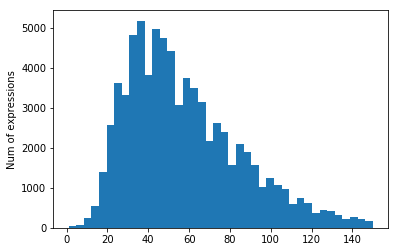

In [283]:
## Make a histogram of how long the sequences.
## Helps us decide on a cut off point

formula_file_path = "data/train.formulas.norm.txt"

formula_lengths = []
image_folder = 'data/images_train/'
image_diagonals = []
image_widths = []
image_heights = []
import math
with open (formula_file_path, "r") as myfile:
    for idx, token_sequence in enumerate(myfile):
        tokens = token_sequence.split()
        formula_lengths.append(len(tokens))
        file_name = str(idx) + '.png'
        image = cv2.imread(image_folder + file_name, 0)
        if image is not None:
            image_heights.append(image.shape[0])
            image_widths.append(image.shape[1])
            
            diagonal = math.sqrt(image.shape[0]**2 + image.shape[1]**2)
            image_diagonals.append(int(diagonal))


        
%matplotlib inline
plt.hist(formula_lengths, normed=False, bins=40)
plt.ylabel('Num of expressions');

In [284]:
height_width_pair = zip(image_heights, image_widths)

height_width_pair_set = set(height_width_pair)
print(len(height_width_pair_set))
height_width_pair_set


19


{(40, 160),
 (40, 200),
 (40, 240),
 (40, 280),
 (40, 320),
 (40, 360),
 (50, 120),
 (50, 200),
 (50, 240),
 (50, 280),
 (50, 320),
 (50, 360),
 (50, 400),
 (60, 360),
 (100, 360),
 (100, 500),
 (160, 400),
 (200, 500),
 (800, 800)}

In [285]:
#encoder_input_data = tf.convert_to_tensor(encoder_input_data)
#target_sequences = tf.convert_to_tensor(target_texts)


#image_dataset = tf.data.Dataset.from_tensor_slices(encoder_input_data)
#seq_dataset = tf.data.Dataset.from_tensor_slices(target_sequences)
#seq_dataset = seq_dataset.map(lambda tgt: tf.string_split([tgt]).values)
#seq_dataset = seq_dataset.map(lambda tgt: tf.cast(target_token_index[tgt], tf.int32))

#seq_dataset = src_dataset.map(lambda tgt: (tgt, tf.size(tgt)))
#seq_dataset = src_dataset.map(lambda tgt: (tf.concat(([target_token_index["**start**"]], tgt), 0),
                                           #tf.concat((tgt, [target_token_index["**end**"]],), 0)))

#seq_dataset = seq_dataset.map(lambda tgt_in, tgt_out: (tgt_in, tgt_out, tf.size(tgt_in)))
                              
#src_tgt_dataset = tf.data.Dataset.zip(image_dataset, seq_dataset)

In [286]:
train_decoder_target_data_batches[0].shape

(32, 50)

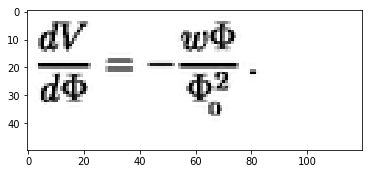

[401 396 174 396 371  54 398 396 371  86 398 398  29  12 396 174 396 392
  86 398 396  86 365 396  62 365 396  16 398 398 364 396  18 398 398 398
  64  14   0   0   0   0   0   0   0   0   0   0   0   0]

[396 174 396 371  54 398 396 371  86 398 398  29  12 396 174 396 392  86
 398 396  86 365 396  62 365 396  16 398 398 364 396  18 398 398 398  64
  14 402   0   0   0   0   0   0   0   0   0   0   0   0]


In [287]:
#encoder_input_data.shape

plt.imshow(train_encoder_input_data_batches[0][0].squeeze(), cmap='gray')
plt.show()


print(train_decoder_input_data_batches[0][0])

print("")
print(train_decoder_target_data_batches[0][0])


In [288]:
tf.reset_default_graph()

In [289]:
## Encoder

## One of Genthails's encoder implementations (from paper)



img = tf.placeholder(tf.uint8, [None, None, None, 1], name='img')

img = tf.cast(img, tf.float32) / 255


batch_size = tf.shape(img)[0]

# Conv + max pooling
out = tf.layers.conv2d(img, 64, 3, 1, "SAME", activation=tf.nn.relu)
# Conv + max pooling
out = tf.layers.conv2d(out, 128, 3, 1, "SAME", activation=tf.nn.relu)

out = tf.layers.conv2d(out, 256, 3, 1, "SAME", activation=tf.nn.relu) # regular conv -> id
out = tf.layers.batch_normalization(out)


out = tf.layers.conv2d(out, 256, 3, 1, "SAME", activation=tf.nn.relu) # regular conv -> id
out = tf.layers.max_pooling2d(out, (2, 1), (2, 1), "SAME")

out = tf.layers.conv2d(out, 512, 3, 1, "SAME", activation=tf.nn.relu) # regular conv -> id
out = tf.layers.max_pooling2d(out, (1, 2), (1, 2), "SAME")


# Conv valid
out = tf.layers.conv2d(out, 512, 3, 1, "VALID", activation=tf.nn.relu, name="last_conv_layer") # conv
out = tf.layers.batch_normalization(out)

## Out is now a H'*W' encoding of the image

## We want to turn this into a sequence of vectors: (e1, e2 ... en)
#H= out.shape[1]
#W= out.shape[2] 
#C= out.shape[3]

H = tf.shape(out)[1]
W = tf.shape(out)[2]

#out = add_timing_signal_nd(out)
seq = tf.reshape(tensor=out, shape=[-1, H*W, 512])

# TODO: Add positional encodings

In [291]:
# First state of the decoder consists of two vectors, the hidden state (h0) and the memory (c0).
# Usually the hidden state refers to [h0, c0]. So a little bit of overloading of hidden state (I think)
# This is how Genthail implements it

#tf.reset_default_graph()

num_units = 512

img_mean = tf.reduce_mean(seq, axis=1)

img_mean = tf.layers.batch_normalization(img_mean)

W = tf.get_variable("W", shape=[512, num_units])
b = tf.get_variable("b", shape=[num_units])
h0 = tf.tanh(tf.matmul(img_mean, W) + b)

W_ = tf.get_variable("W_", shape=[512, num_units])
b_ = tf.get_variable("b_", shape=[num_units])
c0 = tf.tanh(tf.matmul(img_mean, W_) + b_)




encoder_state = tf.contrib.rnn.LSTMStateTuple(c0, h0)





In [292]:
encoder_state

LSTMStateTuple(c=<tf.Tensor 'Tanh_1:0' shape=(?, 512) dtype=float32>, h=<tf.Tensor 'Tanh:0' shape=(?, 512) dtype=float32>)

In [293]:
#attention_states: [batch_size, max_time, num_units]
attention_states = seq


attention_depth = num_units

# Create an attention mechanism
attention_mechanism = tf.contrib.seq2seq.LuongAttention(
    attention_depth, attention_states, scale=True) # Can try scale = False

In [294]:
# Decoder: from seq2seq tutorial 



embedding_size = 80 # In Genthail's paper he says he has 80 embeddings which I believe corresponds to embedding_size

decoder_inputs = tf.placeholder(tf.int32, [None, None], name='decoder_inputs')  # Supposed to be a sequence of numbers corresponding to the different tokens in the sentence

# Embedding of target tokens

# Embedding matrix 
embedding_decoder = tf.get_variable(
    "embedding_encoder", [token_vocab_size, embedding_size], tf.float32, initializer=tf.orthogonal_initializer) #  tf.float32 was default in the NMT tutorial



# Look up embedding:
#   decoder_inputs: [max_time, batch_size]
#   decoder_emb_inp: [max_time, batch_size, embedding_size]
decoder_emb_inp = tf.nn.embedding_lookup(
    embedding_decoder, decoder_inputs)

print(decoder_emb_inp.shape)


(?, ?, 80)


In [295]:

# Build RNN cell
#decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)


# Using this instead compared to NMT tutorial so we can initialize with orthogonal intializer (like Genthail)
decoder_cell = tf.nn.rnn_cell.LSTMCell(
    num_units,
    initializer=tf.orthogonal_initializer,
)

attention = True
if attention:
    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
        decoder_cell, attention_mechanism,
        attention_layer_size=512)

    ## Set initial state of decoder to zero (possible to use previous state)

    use_encoder_state = True
    if use_encoder_state:
        decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32).clone(cell_state=encoder_state)
    else:
        decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32)

else:
    decoder_initial_state = encoder_state

    
decoder_lengths = tf.placeholder(tf.int32, [None])

# Helper
helper = tf.contrib.seq2seq.TrainingHelper(
    decoder_emb_inp, decoder_lengths, time_major=False)

# Projection layer
projection_layer = layers_core.Dense(token_vocab_size, use_bias=False, name="output_projection")# Said layers_core before



In [296]:

# Decoder
decoder = tf.contrib.seq2seq.BasicDecoder(
    decoder_cell, helper, decoder_initial_state,
    output_layer=projection_layer)


In [297]:
print(tf.__version__)
decoder_initial_state

1.5.0-dev20171121


AttentionWrapperState(cell_state=LSTMStateTuple(c=<tf.Tensor 'Tanh_1:0' shape=(?, 512) dtype=float32>, h=<tf.Tensor 'Tanh:0' shape=(?, 512) dtype=float32>), attention=<tf.Tensor 'AttentionWrapperZeroState/zeros_1:0' shape=(?, 512) dtype=float32>, time=<tf.Tensor 'AttentionWrapperZeroState/zeros:0' shape=() dtype=int32>, alignments=<tf.Tensor 'AttentionWrapperZeroState/zeros_2:0' shape=(?, ?) dtype=float32>, alignment_history=())

In [298]:
# Dynamic decoding
outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, output_time_major=False)  ## Understand parameter Impute finished
logits = outputs.rnn_output
print(logits.shape)

(?, ?, 403)


In [302]:
# Exponential learning rate
#starter_learning_rate = 0.0006
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           #5, 0.93, staircase=False)
    
    
    
# Piece wise learning rate

#steps_per_epoch = num_samples / mini_batch_size

global_step = tf.Variable(0, trainable=False)
boundaries = [30,60, 90, 120, 150, 180, 210, 240]  

#boundaries = [steps_per_epoch * epoch ]
values = [0.0001, 0.0001, 0.001, 0.0005, 0.0002, 0.0001, 0.00009, 0.00008, 0.00007]
    
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values, name=None)

In [303]:
#target_weights = tf.placeholder(tf.int8, [None, None], name='target_weights')
#target_weights = tf.cast(target_weights, tf.float32)

# Supposed to be a sequence of numbers corresponding to the different tokens in the sentence
decoder_outputs = tf.placeholder(tf.int32, [None, None], name='decoder_outputs') 



#learning_rate = tf.placeholder(tf.float32, shape=[])    
    
# Loss function

# HYPERPARAMETER: Should we divide by sequence length on each
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=decoder_outputs, logits=logits)

# Create the target_weights (the masking)
max_seq_length = tf.shape(decoder_outputs)[1]
target_weights = tf.sequence_mask(decoder_lengths, max_seq_length, dtype=logits.dtype)


train_loss = tf.reduce_sum(crossent * target_weights) / tf.cast(batch_size, tf.float32)

tf.summary.scalar('loss', train_loss)

# Calculate and clip gradients
params = tf.trainable_variables()
gradients = tf.gradients(train_loss, params)


max_gradient_norm = 3  # Usually a number between 1 and 5. Set to 5 in the NMT.

clipped_gradients, global_norm = tf.clip_by_global_norm(
    gradients, max_gradient_norm)

tf.summary.scalar('global_norm', global_norm)


# Optimization
optimizer = tf.train.AdamOptimizer(learning_rate)
update_step = optimizer.apply_gradients(
    zip(clipped_gradients, params), global_step=global_step)




In [304]:
param_names = [v.name for v in params]

gradient_names = [g.name for g in gradients]

gradient_norms = [tf.norm(gradient) for gradient in gradients]


grads = list(zip(gradients, params))



for grad, var in grads:
    tf.summary.histogram(var.name + '/gradient', grad)

for param in params:
    to_summary = tf.summary.histogram(param.name + '/weight', param)


INFO:tensorflow:Summary name conv2d/kernel:0/gradient is illegal; using conv2d/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d/bias:0/gradient is illegal; using conv2d/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0/gradient is illegal; using conv2d_1/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d_1/bias:0/gradient is illegal; using conv2d_1/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0/gradient is illegal; using conv2d_2/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d_2/bias:0/gradient is illegal; using conv2d_2/bias_0/gradient instead.
INFO:tensorflow:Summary name batch_normalization/gamma:0/gradient is illegal; using batch_normalization/gamma_0/gradient instead.
INFO:tensorflow:Summary name batch_normalization/beta:0/gradient is illegal; using batch_normalization/beta_0/gradient instead.
INFO:tensorflow:Summary name conv2d_3/kernel:0/gradient is illegal; using conv2d_3/kernel_0/gradient i

In [ ]:
# Creating the mask

#decoder_mask_data = np.zeros(shape=(decoder_target_data.shape), dtype=np.int8)
#for idx, decoder_length in enumerate(decoder_lengths_data):
    #decoder_mask_data[idx, :(decoder_length)] = np.ones((1, decoder_length))
    

In [ ]:
# Check so all the input data has the same number of examples




In [305]:
sess = tf.Session()

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('summaries/train/',
                                      sess.graph)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess.run(init)


In [ ]:

# Learning rate_schedule

# Epoch 0 - 2: Warmup with a lower learning rate: (1e-4)
# Epoch 3 - 6: (5e-4)
# Epoch 7 - 20: Exponentially decaying from (5e-4) to (1e-5)

#num_epochs = 400

#mini_batch_size = 128
#num_samples = 0
#steps_per_epoch = num_samples / mini_batch_size
#steps_per_epoch = 1

#def get_learning_rate(global_step, epoch):
    
    #base_learning_rate = 0.0005
    #if epoch < 3:
        #lr_rate = 0.0001
   # elif epoch < 6:
        #lr_rate = 0.0005
    #else:
        # Over 15 epochs decay learning rate from 0.0005 to 0.00001 <=> decay learning rate with .77 per epoch:
        #decay_rate = 0.77
        #decay_steps = steps_per_epoch
        #lr_rate = base_learning_rate * decay_rate ^ ((global_step - steps_per_epoch * 6) / decay_steps)
    
    #return lr_rate

In [306]:
def get_validation_loss():
    num_val_batches = len(val_sequence_lengths_batches)
    val_loss = 0    
    
    for i in range(num_val_batches):


        input_data = {img: val_encoder_input_data_batches[i],
                                        decoder_lengths: val_sequence_lengths_batches[i],
                                         decoder_inputs: val_decoder_input_data_batches[i],
                                          decoder_outputs: val_decoder_target_data_batches[i],
                                         }
   

        output_tensors = [train_loss]

        loss = sess.run(output_tensors, 
                               feed_dict=input_data)

        

        val_loss = val_loss + loss
        

    val_loss = val_loss / len(val_decoder_input_data)

    return val_loss

In [310]:
print("Num batches: ", len(train_sequence_lengths_batches)) #(Note: they are not necessarily equal size towards the end (this will fix later))


15


In [ ]:
## TODO Implement checkpoints

glob_step = 0
num_epochs = 5
val_losses = []
num_train_batches = len(train_sequence_lengths_batches)
print("Num batches: ", num_train_batches)
for epoch in range(num_epochs):

    for i in range(num_train_batches):

        input_data = {img: train_encoder_input_data_batches[i],
                                        decoder_lengths: train_sequence_lengths_batches[i],
                                         decoder_inputs: train_decoder_input_data_batches[i],
                                          decoder_outputs: train_decoder_target_data_batches[i],
                                         }
        
        
        # Only catch important info in the beginning of the epoch
        if (i == 0):
            output_tensors = [merged, update_step,train_loss, optimizer._lr, global_norm, gradient_norms, global_step]
            summary, _, loss, lr_rate, global_grad_norm, grad_norms, glob_step = sess.run(output_tensors, 
                               feed_dict=input_data)
            train_writer.add_summary(summary, glob_step)
            
        else:
            output_tensors = [update_step, train_loss, global_norm, global_step, optimizer._lr]
            _, loss, global_grad_norm, glob_step, lr_rate  = sess.run(output_tensors, 
                               feed_dict=input_data)

        

        # Write to tensorboard every 10th step
        if glob_step % 40 == 0:
            train_writer.add_summary(summary, glob_step)

        if i == 0:
            print("Epoch: ", epoch)
            

        print("i: ", i)
        #if glob_step % 5 == 0:
        print('Step %d: loss = %.2f' % (glob_step, loss))
        print("Learning rate: ", lr_rate)
        print("Global grad norm: ", global_grad_norm)

    val_loss = get_validation_loss()
    val_losses.append(val_loss)
    print("Val loss: ", val_loss)
    
## Run the following in terminal to get up tensorboard: tensorboard --logdir=summaries/train        


('Num batches: ', 15)
('Epoch: ', 0)
('i: ', 0)
Step 16: loss = 114.26
('Learning rate: ', 9.9999997e-05)
('Global grad norm: ', 444.34158)
('i: ', 1)
Step 17: loss = 114.26
('Learning rate: ', 9.9999997e-05)
('Global grad norm: ', 318.50534)
('i: ', 2)
Step 18: loss = 114.26
('Learning rate: ', 9.9999997e-05)
('Global grad norm: ', 347.52213)


In [ ]:


saver.save(sess, 'my-test-model')

In [ ]:
#inference

tgt_sos_id = target_token_index['**start**'] # 4
tgt_eos_id = target_token_index['**end**'] # 3

# Helper
helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
    embedding_decoder,
    tf.fill([10], tgt_sos_id), tgt_eos_id)

maximum_iterations = 15 # Do max seq_length or find some other heuristic

# Decoder
decoder = tf.contrib.seq2seq.BasicDecoder(
    decoder_cell, helper, decoder_initial_state,
    output_layer=projection_layer)
# Dynamic decoding
outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
    decoder, maximum_iterations=maximum_iterations)
translations = outputs.sample_id



In [ ]:
trans = sess.run(translations, feed_dict = {img: encoder_input_data[:20]})

In [ ]:


trans




In [ ]:
decoder_target_data

In [ ]:
def get_token_seq(int_sequence):
    
    output_string = ""
    for value in int_sequence:
        output_string += reverse_target_token_index[value]
        if reverse_target_token_index[value] == "**end**":
            break
    return output_string

In [ ]:

for idx, seq in enumerate(decoder_target_data):
    
    print("Output: ")
    print(get_token_seq(trans[idx]))
    
    print("Ground truth: ")
    print(get_token_seq(seq))